# Code

Related to / based on Karpathy videos / code at https://github.com/karpathy/nn-zero-to-hero and https://github.com/karpathy/nanoGPT.

In [1]:
import logging
import math
import time
from collections.abc import Iterator
from pathlib import Path
from typing import Literal

import httpx
import matplotlib.pyplot as plt
import numpy as np
import tiktoken
import torch


logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s: %(message)s"
)
logger = logging.getLogger(__name__)

### Torch Helpers

In [2]:
def set_torch_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


def get_torch_device() -> str:
    return (
        "cuda" if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available()
        else "cpu"
    )

### Networks

In [3]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(
        self,
        max_context_size: int,
        input_dim: int,
        head_size: int,
        p_dropout: float,
        num_heads: int,
        p_multihead_dropout: float,
    ) -> None:
        super().__init__()
        output_dim = head_size * num_heads
        self._key_query_value = torch.nn.Linear(input_dim, 3 * output_dim, bias=False)
        self._dropout = torch.nn.Dropout(p_dropout)
        self._projection = torch.nn.Linear(output_dim, output_dim)
        self._multi_head_dropout = torch.nn.Dropout(p_multihead_dropout)

        self._num_heads = num_heads
        self._head_size = head_size
        
        tril = torch.tril(torch.ones(max_context_size, max_context_size))
        self.register_buffer("tril", tril)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        input_shape = x.shape
        # x is (batch_size, context_size, input_dim)
        # _key_query_value is (input_dim, 3 * head_size * num_heads)

        kqv = self._key_query_value(x).view(x.shape[:-1] + (self._num_heads, self._head_size, 3))
        # kqv: (batch_size, context_size, num_heads, head_size, 3)
        keys = kqv[..., 0].transpose(1, 2)
        queries = kqv[..., 1].transpose(1, 2)
        values = kqv[..., 2].transpose(1, 2)
        # keys, queries, values are (batch_size, num_heads, context_size, head_size)
        
        weights = queries @ keys.transpose(-2, -1) * self._head_size ** -0.5
        # weights is (batch_size, num_heads, head_size, head_size)

        context_size = x.shape[-2]
        context_tril = self.tril[:context_size, :context_size]
        weights = weights.masked_fill(context_tril == 0, float("-inf"))
        weights = torch.nn.functional.softmax(weights, dim=-1)
        # weights is still (batch_size, num_heads, head_size, head_size)

        weights = self._dropout(weights)
        result = weights @ values
        # result is (batch_size, context_size, head_size)

        output_dim = self._num_heads * self._head_size
        result = result.transpose(1, 2).contiguous().view(input_shape[:-1] + (output_dim, ))
        result = self._projection(result)
        result = self._multi_head_dropout(result)
        return result


non_linearities = {
    "relu": torch.nn.ReLU,
    "gelu": torch.nn.GELU,
}


class FeedForward(torch.nn.Module):
    def __init__(
        self,
        n_input: int,
        n_hidden: int,
        non_linearity: Literal["relu", "gelu"],
        n_output: int,
        p_dropout: float,
    ) -> None:
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(n_input, n_hidden),
            non_linearities[non_linearity](),
            torch.nn.Linear(n_hidden, n_output),
            torch.nn.Dropout(p_dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


class AttentionBlock(torch.nn.Module):
    def __init__(
        self,
        max_context_size: int,
        input_dim: int,
        p_attention_dropout: float,
        num_attention_heads: int,
        p_multihead_attention_dropout: float,
        feed_forward_mult: int,
        ff_nonlinearity: Literal["relu", "gelu"],
        p_ffwd_dropout: float,
    ) -> None:
        super().__init__()
        if input_dim % num_attention_heads != 0:
            msg = (
                f"Input dimension {input_dim} should be "
                f"exactly divisible by {num_attention_heads}"
            )
            raise Exception(msg)

        head_size = input_dim // num_attention_heads
        self._attention_layer_norm = torch.nn.LayerNorm(input_dim)
        self._attention = MultiHeadAttention(
            max_context_size,
            input_dim,
            head_size,
            p_attention_dropout,
            num_attention_heads,
            p_multihead_attention_dropout,
        )
        self._ffwd_layer_norm = torch.nn.LayerNorm(input_dim)
        attention_output_dim = head_size * num_attention_heads
        self._feed_forward = FeedForward(
            attention_output_dim,
            attention_output_dim * feed_forward_mult,
            ff_nonlinearity,
            input_dim,
            p_ffwd_dropout,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self._attention(self._attention_layer_norm(x))
        x = x + self._feed_forward(self._ffwd_layer_norm(x))
        return x


class Model(torch.nn.Module):
    def __init__(
        self,
        vocab_size: int,
        n_embeddings: int,
        max_context_size: int,
        num_attention_heads: int,
        feed_forward_mult: int,
        p_dropout: float,
        ff_nonlinearity: str,
        num_blocks: int,
    ) -> None:
        super().__init__()
        self._token_embedding_table = torch.nn.Embedding(vocab_size, n_embeddings)
        self._position_embedding_table = torch.nn.Embedding(max_context_size, n_embeddings)
        self._attention_blocks = torch.nn.Sequential(
            *[
                AttentionBlock(
                    max_context_size,
                    n_embeddings,
                    p_dropout,
                    num_attention_heads,
                    p_dropout,
                    feed_forward_mult,
                    ff_nonlinearity,
                    p_dropout,
                )
                for _ in range(num_blocks)
            ],
        )
        self._final_layer_norm = torch.nn.LayerNorm(n_embeddings)
        self._final_linear = torch.nn.Linear(n_embeddings, vocab_size)
        self._max_context_size = max_context_size

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor | None = None):
        inputs = inputs[:, -self._max_context_size:]
        batch_size, block_size = inputs.shape
        # inputs: (batch_size, block_size)
        # targets: (batch_size, block_size)

        token_embeddings = self._token_embedding_table(inputs)
        position_embeddings = self._position_embedding_table(torch.arange(block_size, device=inputs.device))
        x = token_embeddings + position_embeddings
        # x is (batch_size, block_size, n_embeddings)
        x = self._attention_blocks(x)
        logits = self._final_linear(self._final_layer_norm(x))
        # # logits is (batch_size, block_size, vocab_size)
        return logits


def _test_model() -> None:
    torch_device = get_torch_device()

    vocab_size = 11
    n_embeddings = 9
    max_context_size = 7
    num_attention_heads = 3
    feed_forward_mult = 4
    p_dropout = 0.15
    num_blocks = 3
    
    model = Model(
        vocab_size,
        n_embeddings,
        max_context_size,
        num_attention_heads,
        feed_forward_mult,
        p_dropout,
        "relu",
        num_blocks,
    ).to(torch_device)

    batch_size = 32
    context_size = 4
    x = torch.ones((batch_size, context_size), dtype=torch.long, device=torch_device)
    logits = model(x)
    assert logits.shape == (batch_size, context_size, vocab_size)


_test_model()

### Model Evaluation

In [4]:
@torch.no_grad()
def generate_samples(model, input: str, encoder, max_new_tokens: int, n_samples: int) -> list[str]:
    torch_device = next(model.parameters()).device
    tokens = [encoder.encode(input)] * n_samples
    values = torch.tensor(tokens).to(torch_device)

    for _ in range(max_new_tokens):
        logits = model(values)
        logits = logits[:, -1, :]
        probs = torch.nn.functional.softmax(logits, dim=-1)
        next_value = torch.multinomial(probs, num_samples=1)
        values = torch.cat((values, next_value), dim=1)

    return [encoder.decode(sample.tolist()) for sample in values]


@torch.no_grad()
def estimate_loss(model, loss_fn, dataloader, n_batches):
    model.eval()
    losses = torch.zeros(n_batches)
    torch_device = next(model.parameters()).device
    for k in range(n_batches):
        inputs, targets = next(dataloader)
        logits = model(inputs.to(torch_device))
        loss = loss_fn(logits, targets.to(torch_device))
        losses[k] = loss.item()

    model.train()
    return losses.mean().item(), losses.std().item() / np.sqrt(len(losses))


def count_params(model, depth: int = 0):
    params = {name: param.numel() for name, param in model.named_parameters()}

    result = {}
    for name, param in params.items():
        adjusted_name = ".".join(name.split(".")[:depth])
        result[adjusted_name] = result.get(adjusted_name, 0) + param

    return result

### Data

In [5]:
def get_data(url: str, cache_path: str) -> str:
    file = Path(cache_path)
    if not file.exists():
        logger.info(f"Loading {url} from remote")
        file.parent.mkdir(parents=True, exist_ok=True)
        with open(file, "w") as file:
            res = httpx.get(url)
            file.write(res.text)
        return res.text

    logger.info(f"Loading {url} from cache at {cache_path}")
    with open(cache_path, "r") as file:
        return file.read()


def _test_get_data() -> None:
    test_path = "./data/testing.txt"
    url = "https://pytorch.org/"

    Path(test_path).unlink(missing_ok=True)

    res = get_data(url, test_path)
    print(f"{url} contents length {len(res)}")
    assert len(res) > 0
    assert Path(test_path).exists()
    res2 = get_data(url, test_path)
    print(f"Cached contents length {len(res2)}")

    Path(test_path).unlink()


_test_get_data()

2025-01-23 14:34:33,973 - INFO: Loading https://pytorch.org/ from remote
2025-01-23 14:34:34,168 - INFO: HTTP Request: GET https://pytorch.org/ "HTTP/1.1 200 OK"
2025-01-23 14:34:34,170 - INFO: Loading https://pytorch.org/ from cache at ./data/testing.txt


https://pytorch.org/ contents length 52835
Cached contents length 52835


In [6]:
class EpochDataLoader():
    def __init__(self, tokens: list[int], context_size: int, batch_size: int) -> None:
        self._context_size = context_size
        self._batch_size = batch_size
        
        full_length = len(tokens)
        tokens_per_batch = context_size * batch_size
        num_batches = (full_length - 1) // tokens_per_batch
        batched_length = tokens_per_batch * num_batches
        self._used_tokens = torch.tensor(tokens[:(batched_length + 1)])
        
        starting_indices = context_size * torch.randperm(num_batches * batch_size).view(-1, batch_size, 1)
        self._indices = starting_indices + torch.arange(context_size).view(1, 1, context_size)

    def __len__(self) -> int:
        return len(self._indices)

    def __iter__(self) -> Iterator[tuple[torch.Tensor, torch.Tensor]]:
        for ixs in self._indices:
            inputs = (
                torch.gather(self._used_tokens, 0, ixs.view(-1))
                .view(self._batch_size, self._context_size)
            )
            targets = (
                torch.gather(self._used_tokens, 0, ixs.view(-1) + 1)
                .view(self._batch_size, self._context_size)
            )
            yield inputs, targets


class RandomDataLoader:
    def __init__(self, tokens: list[int], context_size: int, batch_size: int) -> None:
        self._data = torch.tensor(tokens)
        self._context_size = context_size
        self._batch_size = batch_size

    def __len__(self) -> int:
        return len(self._data) // (self._context_size * self._batch_size)

    def __iter__(self) -> Iterator[tuple[torch.Tensor, torch.Tensor]]:
        return self

    def __next__(self) -> tuple[torch.Tensor, torch.Tensor]:
        # returns tuple of 2D tensors, (batch_size, block_size)
        starting_indices = torch.randint(len(self._data) - self._context_size, (self._batch_size, ))
        indices = torch.arange(self._context_size).unsqueeze(0) + starting_indices.unsqueeze(1)
        inputs = torch.gather(self._data, 0, indices.view(-1)).view(self._batch_size, self._context_size)
        targets = torch.gather(self._data, 0, indices.view(-1) + 1).view(self._batch_size, self._context_size)
        return inputs, targets


def _test_epoch_dataloader() -> None:
    data = list(range(100))
    context_size = 3
    batch_size = 8
    dataloader = EpochDataLoader(data, context_size, batch_size)
    assert len(dataloader) == 4
    all_inputs = []
    all_targets = []
    for inputs, targets in dataloader:
        assert inputs.shape == (batch_size, context_size)
        assert targets.shape == (batch_size, context_size)
        assert (inputs[:, 1:] == targets[:,:-1]).all()
        all_inputs.append(inputs.view(-1))
        all_targets.append(targets.view(-1))

    input_lst = list(sorted(torch.concat(all_inputs).tolist()))
    target_lst = list(sorted(torch.concat(all_targets).tolist()))
    assert len(input_lst) == len(data) - (len(data) % (context_size * batch_size))
    assert input_lst == data[:len(input_lst)]

    assert len(target_lst) == len(input_lst)
    assert target_lst == data[1:(len(input_lst) + 1)]


def _test_random_dataloader() -> None:
    data = list(range(100))
    context_size = 3
    batch_size = 8
    dataloader = RandomDataLoader(data, context_size, batch_size)
    data = iter(dataloader)
    inputs, targets = next(data)
    assert inputs.shape == (batch_size, context_size)
    assert targets.shape == (batch_size, context_size)
    assert (inputs[:, 1:] == targets[:,:-1]).all()

    inputs2, targets2 = next(data)
    assert (inputs2 != inputs).any()
    assert (targets2 != targets).any()


_test_epoch_dataloader()
_test_random_dataloader()

### Encoding

In [7]:
class CharacterEncoder:
    def __init__(self, text: str):
        tokens = sorted(list(set(text)))
        self._token_lookup = {char: i for i, char in enumerate(tokens)}
        self._reverse_token_lookup = {i: char for char, i in self._token_lookup.items()}

        logger.info(f"Token count = {len(tokens)} ({repr(''.join(tokens))})")

    @property
    def n_vocab(self) -> int:
        return len(self._token_lookup)

    def encode(self, string: str) -> list[int]:
        return [self._token_lookup[char] for char in string]

    def decode(self, values: str) -> str:
        return "".join([self._reverse_token_lookup[value] for value in values])


def get_encoding(name: str, *args, **kwargs):
    if name == "char":
        return CharacterEncoder(*args, **kwargs)
    return tiktoken.get_encoding(name, *args, **kwargs)


def _test_get_encoding() -> None:
    text = "hello world!"
    
    encoder = get_encoding("gpt2")
    tokens = encoder.encode(text)
    text_again = encoder.decode(tokens)
    assert text_again == text
    assert encoder.n_vocab == 50257

    encoder = get_encoding("char", text)
    tokens = encoder.encode(text)
    text_again = encoder.decode(tokens)
    assert text_again == text
    assert encoder.n_vocab == 9


_test_get_encoding()

2025-01-23 14:34:34,351 - INFO: Token count = 9 (' !dehlorw')


# Running

In [8]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
cache_path = "./data/tiny_shakespeare.txt"
full_text = get_data(url, cache_path)
print(f"Length of training data = {len(full_text):,}")

2025-01-23 14:34:34,355 - INFO: Loading https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt from cache at ./data/tiny_shakespeare.txt


Length of training data = 1,115,394


In [9]:
small_model_settings = {
    "max_context_size": 8,
    "n_embeddings": 8 * 4,
    "num_attention_heads": 4,
    "feed_forward_mult": 4,
    "p_dropout": 0.2,
    "ff_nonlinearity": "relu",
    "num_blocks": 3,
}

large_model_settings = {
    "max_context_size": 128,
    "n_embeddings": 32 * 4,
    "num_attention_heads": 4,
    "feed_forward_mult": 4,
    "p_dropout": 0.2,
    "ff_nonlinearity": "relu",
    "num_blocks": 4,
}

In [10]:
test_train_split = 0.9
encoder = get_encoding("char", full_text)
logging.info(f"Encoder dimension {encoder.n_vocab}")

settings = large_model_settings

opt_settings = {
    "batch_size": 64,
    "learning_rate": 3e-4,
    "n_steps": 10000,
}

reporting_settings = {
    "reports_per_epoch": 2,
    "test_batches": 50,
}

def cross_entropy_loss(inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    vocab_size = inputs.shape[-1]
    return torch.nn.functional.cross_entropy(inputs.view(-1, vocab_size), targets.view(-1))

loss_fn = cross_entropy_loss

2025-01-23 14:34:34,369 - INFO: Token count = 65 ("\n !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")
2025-01-23 14:34:34,369 - INFO: Encoder dimension 65


In [11]:
n_split = int(test_train_split * len(full_text))
train_text = full_text[:n_split]
test_text = full_text[n_split:]

set_torch_seed(123)

training_dataloader = EpochDataLoader(encoder.encode(train_text), settings["max_context_size"], opt_settings["batch_size"])
testing_dataloader = RandomDataLoader(encoder.encode(test_text), settings["max_context_size"], opt_settings["batch_size"])

model = Model(
    vocab_size=encoder.n_vocab,
    n_embeddings=settings["n_embeddings"],
    max_context_size=settings["max_context_size"],
    num_attention_heads=settings["num_attention_heads"],
    feed_forward_mult=settings["feed_forward_mult"],
    p_dropout=settings["p_dropout"],
    ff_nonlinearity=settings["ff_nonlinearity"],
    num_blocks=settings["num_blocks"],
)
torch_device = get_torch_device()
model = model.to(torch_device)
logging.info(f"Model parameter count = {count_params(model, 0)['']:,}")
for desc, count in count_params(model, 2).items():
    logging.info(f"---- {desc}: {count:,}")
samples = generate_samples(model, "\n", encoder, 100, 1)
for i, sample in enumerate(samples):
    logging.info(f"Sample {i + 1}: {repr(sample)}")
test_loss, test_loss_std = estimate_loss(model, loss_fn, testing_dataloader, reporting_settings["test_batches"])
logging.info(f"Initial test loss = {test_loss:.3f}±{test_loss_std:.3f}")

optimizer = torch.optim.AdamW(model.parameters(), lr=opt_settings["learning_rate"])

steps_per_epoch = len(training_dataloader)
n_epochs = math.ceil(opt_settings["n_steps"] / steps_per_epoch)
logging.info(f"Running {steps_per_epoch} for every {n_epochs} epochs, total {n_epochs * steps_per_epoch} steps")
report_interval = steps_per_epoch // reporting_settings["reports_per_epoch"]
n_batches = []
training_losses = []
test_losses = []
times = []
training_losses_accumulator = []

start_time = time.monotonic()

for epoch in range(n_epochs):
    logger.info(f"----- Epoch {epoch + 1} --- (lr = {optimizer.param_groups[0]["lr"]:.3g}) -----")
    for step, (inputs, targets) in enumerate(training_dataloader):
        full_step = epoch * steps_per_epoch + step
        logits = model(inputs.to(torch_device))
        loss = loss_fn(logits, targets.to(torch_device))
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if ((step + 1) % report_interval) > (report_interval - 5):
            training_losses_accumulator.append(loss.item())
    
        if (step + 1) % report_interval == 0:
            training_loss = np.mean(training_losses_accumulator)
            training_loss_std = np.std(training_losses_accumulator) / np.sqrt(len(training_losses_accumulator))
            training_losses_accumulator = []
            test_loss, test_loss_std = estimate_loss(model, loss_fn, testing_dataloader, reporting_settings["test_batches"])
            
            now_time = time.monotonic()
            time_diff = now_time - start_time
            if step != 0:
                token_rate = inputs.numel() * report_interval / time_diff
            else:
                token_rate = inputs.numel() / time_diff
            start_time = now_time
    
            n_batches.append(full_step)
            training_losses.append(training_loss)
            test_losses.append(test_loss)
            times.append(time_diff)
            remaining_time = (steps_per_epoch - step - 1 + (n_epochs - epoch - 1) * steps_per_epoch) * time_diff / report_interval
            msg = (
                f"Step {full_step + 1}: training_loss={training_loss:.3f}±{training_loss_std:.3f}, "
                f"test_loss={test_loss:.3f}±{test_loss_std:.3f}, "
                f"time_diff={time_diff:.3g}, "
                f"token_rate={token_rate:.3g}/s "
                f"(remaining={remaining_time:.1f}s)"
            )
            logger.info(msg)

test_loss, test_loss_std = estimate_loss(model, loss_fn, testing_dataloader, reporting_settings["test_batches"])
logger.info(f"Final: training_loss={loss.item():.3f}, test_loss={test_loss:.3f}±{test_loss_std:.3f}")
samples = generate_samples(model, "\n", encoder, 100, 3)
for i, sample in enumerate(samples):
    logging.info(f"Sample {i + 1}: {repr(sample)}")

2025-01-23 14:34:34,513 - INFO: Model parameter count = 824,897
2025-01-23 14:34:34,513 - INFO: ---- _token_embedding_table.weight: 8,320
2025-01-23 14:34:34,514 - INFO: ---- _position_embedding_table.weight: 16,384
2025-01-23 14:34:34,514 - INFO: ---- _attention_blocks.0: 197,888
2025-01-23 14:34:34,514 - INFO: ---- _attention_blocks.1: 197,888
2025-01-23 14:34:34,514 - INFO: ---- _attention_blocks.2: 197,888
2025-01-23 14:34:34,514 - INFO: ---- _attention_blocks.3: 197,888
2025-01-23 14:34:34,514 - INFO: ---- _final_layer_norm.weight: 128
2025-01-23 14:34:34,515 - INFO: ---- _final_layer_norm.bias: 128
2025-01-23 14:34:34,515 - INFO: ---- _final_linear.weight: 8,320
2025-01-23 14:34:34,515 - INFO: ---- _final_linear.bias: 65
2025-01-23 14:34:41,241 - INFO: Sample 1: "\n:HW!M&,CVtwGzO$V\ns.NGfTX.C3h.B T.J'jJGpubMyllWidOV$yK \nBcGrdYcR'G.us.wIDTX3IsU:'fCLsJGfF!FZZiVC;pMJg"
2025-01-23 14:34:41,940 - INFO: Initial test loss = 4.344±0.001
2025-01-23 14:34:42,490 - INFO: Running 122 for ev

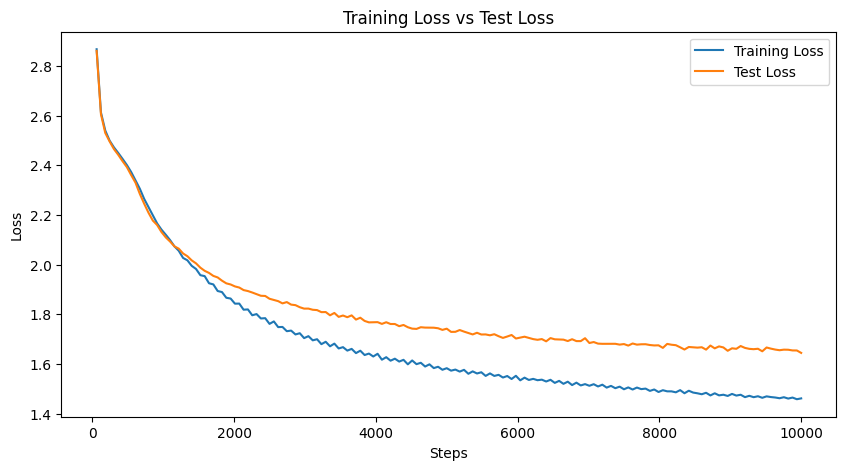

In [12]:
def plot_losses(training_losses: list[float], test_losses: list[float], n_batches: list[int]) -> None:
    plt.figure(figsize=(10, 5))
    plt.plot(n_batches, training_losses, label='Training Loss')
    plt.plot(n_batches, test_losses, label='Test Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Test Loss')
    plt.legend()
    plt.show()


plot_losses(training_losses, test_losses, n_batches)